# PyTree integrations

[https://indico.cern.ch/event/1566263/timetable/#27-pytrees-for-vectors](https://indico.cern.ch/event/1566263/timetable/#27-pytrees-for-vectors)

Credit: Nick Smith [FNAL]

PyTrees are a [powerful mechanism](https://blog.scientific-python.org/pytrees/) for working with
nested data structures, while allowing algorithms like finite-differences, minimization, and integration routines
to run on flattened 1D arrays of the the same data. To use PyTrees with vector objects, you need to install
the [optree](https://github.com/metaopt/optree) package, and then register vector with PyTrees, for example:

In [10]:
import vector

pytree = vector.register_pytree()

state = {
    "position": vector.obj(x=1, y=2, z=3, t=0),
    "momentum": vector.obj(x=0, y=10, z=0, t=14),
}
flat_state, treedef = pytree.flatten(state)

`flat_state` is now a 1D array of length 8, and `treedef` contains the information needed to reconstruct the original structure:



In [11]:
print(flat_state)
print(treedef)

[0, 10, 0, 14, 1, 2, 3, 0]
PyTreeSpec({'momentum': CustomTreeNode(VectorObject4D[(<class 'vector.backends.object.VectorObject4D'>, <class 'vector.backends.object.AzimuthalObjectXY'>, <class 'vector.backends.object.LongitudinalObjectZ'>, <class 'vector.backends.object.TemporalObjectT'>)], [(*, *), (*,), (*,)]), 'position': CustomTreeNode(VectorObject4D[(<class 'vector.backends.object.VectorObject4D'>, <class 'vector.backends.object.AzimuthalObjectXY'>, <class 'vector.backends.object.LongitudinalObjectZ'>, <class 'vector.backends.object.TemporalObjectT'>)], [(*, *), (*,), (*,)])}, namespace='vector')


The original structure can be reconstructed with:

In [12]:
reconstructed_state = pytree.unflatten(treedef, flat_state)
print(reconstructed_state)

{'position': VectorObject4D(x=1, y=2, z=3, t=0), 'momentum': VectorObject4D(x=0, y=10, z=0, t=14)}


Numpy vector arrays are also supported:

In [13]:
import numpy as np

pos = vector.array(
    {
        "x": np.array([1.0, 2.0, 3.0]),
        "y": np.array([4.0, 5.0, 6.0]),
    }
)
flat_p0, unravel = pytree.ravel(pos)

print(flat_p0)
unravel(flat_p0)

[1. 4. 2. 5. 3. 6.]


VectorNumpy2D([(1., 4.), (2., 5.), (3., 6.)], dtype=[('x', '<f8'), ('y', '<f8')])

## Example: projectile motion with air resistance

In the following example, we use `scipy.integrate.solve_ivp` to solve the equations of motion for a projectile under the influence of gravity and air resistance.

To start, we wrap the solver, using PyTrees to flatten the state dictionary into a 1D array for the integrator, and then unflatten the result back into the original structure

In [20]:
from scipy.integrate import solve_ivp


def wrapped_solve(fun, t_span, y0, t_eval):
    flat_y0, treedef = pytree.flatten(y0)

    print("[wrapped_solve] y0:")
    print(y0)
    print("[wrapped_solve] pytree.flatten(y0):")
    print(flat_y0)
    def flat_fun(t, flat_y):
        state = pytree.unflatten(treedef, flat_y)
        dstate_dt = fun(t, state)
        flat_dstate_dt, _ = pytree.flatten(dstate_dt)
        return flat_dstate_dt

    flat_solution = solve_ivp(
        fun=flat_fun,
        t_span=t_span,
        y0=flat_y0,
        t_eval=t_eval,
    )
    return pytree.unflatten(treedef, flat_solution.y)

Now, we set up the physical constants and initial conditions for the projectile motion problem, using the [hepunits](https://github.com/scikit-hep/hepunits) library to help us consistently track units throughout the calculation.

In [21]:
import numpy as np
import hepunits as u

gravitational_acceleration = vector.obj(x=0.0, y=-9.81) * (u.m / u.s**2)
air_density = 1.25 * u.kg / u.meter3
drag_coefficient = 0.47  # for a sphere
object_radius = 10 * u.cm
object_area = np.pi * object_radius**2
object_mass = 1.0 * u.kg

initial_position = vector.obj(
    x=0 * u.m,
    y=0 * u.m,
)
initial_momentum = (
    vector.obj(
        x=1 * u.m / u.s,
        y=20 * u.m / u.s,
    )
    * object_mass
)

The `force` function computes the total force on the object, including both gravity and air resistance. The `tangent` function then uses this to compute the time derivatives of position and momentum.

In [22]:
def force(position: vector.Vector2D, momentum: vector.Vector2D):
    gravitational_force = object_mass * gravitational_acceleration
    speed = momentum.rho / object_mass
    drag_magnitude = 0.5 * air_density * speed**2 * drag_coefficient * object_area
    drag_force = -drag_magnitude * momentum.unit()
    return gravitational_force + drag_force


def tangent(t: float, state):
    position, momentum = state
    dposition_dt = momentum / object_mass
    dmomentum_dt = force(position, momentum)
    return (dposition_dt, dmomentum_dt)

Finally, we solve the equations of motion using our wrapped `solve_ivp`, alongside computing an analytic solution without air resistance for comparison.

In [24]:
time = np.linspace(0, 4, 100) * u.s

position, momentum = wrapped_solve(
    fun=tangent,
    t_span=(time[0], time[-1]),
    y0=(initial_position, initial_momentum),
    t_eval=time,
)

position_no_drag = (
    initial_momentum / object_mass * time + 0.5 * gravitational_acceleration * time**2
)


[wrapped_solve] y0:
(VectorObject2D(x=0.0, y=0.0), VectorObject2D(x=6.241509074460761e+18, y=1.2483018148921524e+20))
[wrapped_solve] pytree.flatten(y0):
[0.0, 0.0, 6.241509074460761e+18, 1.2483018148921524e+20]


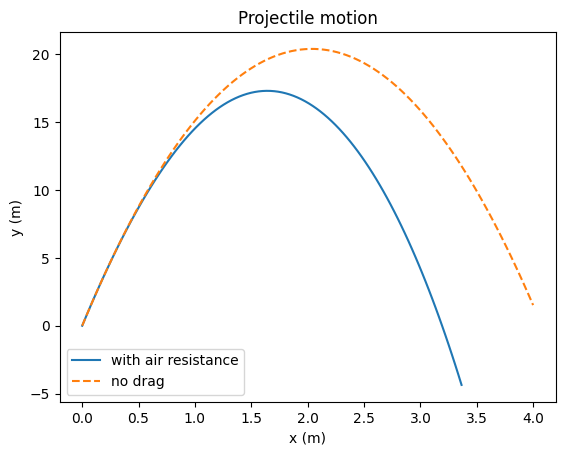

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(position.x / u.m, position.y / u.m, label="with air resistance")
ax.plot(position_no_drag.x / u.m, position_no_drag.y / u.m, ls="--", label="no drag")
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
ax.set_title("Projectile motion")
ax.legend();

# Further directions

Awkward arrays are not yet supported, but could be added in future releases.
This may also allow for easy integration with JAX and other libraries that use PyTrees.